# Load the data

In [149]:
#Processing
import pandas as pd
import numpy as np
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA, TruncatedSVD, FastICA
from sklearn.model_selection import KFold, cross_val_score
from sklearn.random_projection import GaussianRandomProjection, SparseRandomProjection
from sklearn.preprocessing import normalize
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score, roc_auc_score

#Plotting
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew

In [150]:
train = pd.read_csv('data/challenge2_train.csv')
test = pd.read_csv('data/challenge2_test.csv')

# Exploratory Data Analysis

## Get an overview of the data

First, we want to know what kind of data we are dealing with.

In [151]:
train.columns

Index(['id', 'target', 'f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8',
       'f9', 'f10', 'f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18',
       'f19', 'f20', 'f21', 'f22', 'f23', 'f24'],
      dtype='object')

In [152]:
test.columns

Index(['id', 'f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10',
       'f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18', 'f19', 'f20',
       'f21', 'f22', 'f23', 'f24'],
      dtype='object')

In [153]:
train.info()
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 27 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      50000 non-null  int64  
 1   target  50000 non-null  int64  
 2   f0      45122 non-null  float64
 3   f1      50000 non-null  int64  
 4   f2      48816 non-null  float64
 5   f3      49677 non-null  float64
 6   f4      46621 non-null  object 
 7   f5      26130 non-null  float64
 8   f6      46648 non-null  float64
 9   f7      49517 non-null  float64
 10  f8      48540 non-null  object 
 11  f9      49497 non-null  float64
 12  f10     28585 non-null  float64
 13  f11     49894 non-null  float64
 14  f12     48487 non-null  object 
 15  f13     49497 non-null  float64
 16  f14     29937 non-null  float64
 17  f15     49057 non-null  float64
 18  f16     49020 non-null  float64
 19  f17     48630 non-null  object 
 20  f18     48749 non-null  float64
 21  f19     45121 non-null  float64
 22

We see from the column names that both the training and test set includes IDs. As the data is anonymized and the IDs are unique, we do not want them to affect the training, and therefore drop them for now.

We also want to separate the targets from the samples during training so we can use them for validation.

In [154]:
X_train = train.drop(["id"], axis=1)
Y_train = train["target"].values

In [155]:
X_test = test.drop(["id"], axis=1)

Let's explore the shape and content of the data.

In [156]:
X_train.head()

,target,f0,f1,f2,f3,f4,f5,f6,f7,f8,...,f15,f16,f17,f18,f19,f20,f21,f22,f23,f24
0,0,1013.1,0,5.0190,26.1,bbd,11.1,33.0,11.0,m,...,19.0,27.8,bbd,6.0,1008.9,1.0,nd,17.4,61.0,63.0
1,0,1010.2,1,5.0142,10.4,n,NaN,46.0,17.0,k,...,22.0,12.7,n,12.0,1012.4,5.0,nx,6.8,55.0,80.0
2,0,1014.4,2,5.0280,12.3,xnx,NaN,31.0,13.0,c,...,9.0,13.0,nnd,7.0,1016.1,NaN,nx,10.1,61.0,70.0
3,0,1019.2,3,5.0335,23.0,nx,11.6,41.0,9.0,i,...,17.0,32.3,nx,10.0,1016.6,1.0,dnd,14.4,NaN,40.0
4,0,1027.6,4,5.0129,7.3,d,7.3,28.0,15.0,h,...,13.0,13.7,dnd,7.0,1024.4,7.0,dbd,6.8,47.0,92.0


In [157]:
X_train.shape

(50000, 26)

In [158]:
Y_train.shape

(50000,)

In [159]:
X_test.shape

(50000, 25)

From `.info()` and `.head()`, we can see that some of the features include categorical data. We want to figure out how many categories each of these feature include.

In [160]:
X_train['f4'].describe()

count     46621
unique       16
top           x
freq       3410
Name: f4, dtype: object

In [161]:
X_train['f8'].describe()

count     48540
unique       15
top           n
freq       5845
Name: f8, dtype: object

In [162]:
X_train['f17'].describe()

count     48630
unique       16
top          nd
freq       3762
Name: f17, dtype: object

In [163]:
X_train['f21'].describe()

count     46416
unique       16
top           b
freq       3996
Name: f21, dtype: object

Seems like most of them have 16 unique categories, but f8 has 15. It might be that f8 also has 16 categories, but only 15 of them are observed in the training data. This implies that unseen categories can show up during prediction, and should be handled.

One of the features, f12, consists of hex values:

In [164]:
X_train['f12'].head()

0    be42001f3
1    3aad93cab
2    90116a97d
3    dc4ee566b
4    f09cc205f
Name: f12, dtype: object

It is also worth noting that f9 values are binary. That means this feature represents a variable which is either true or false:

In [165]:
X_train['f9'].head()

0    0.0
1    0.0
2    1.0
3    0.0
4    1.0
Name: f9, dtype: float64

Let's define which columns are categorical, hex valued and binary so we can remember it for later.

In [166]:
# Define which columns include categorical data
cat_cols = ['f4', 'f8', 'f17', 'f21']

# Columns containing hex values
hex_col = 'f12'

bin_col = 'f9'

## Target balance

Class 0: 38734
Class 1: 11266
Proportion: 3.44 : 1


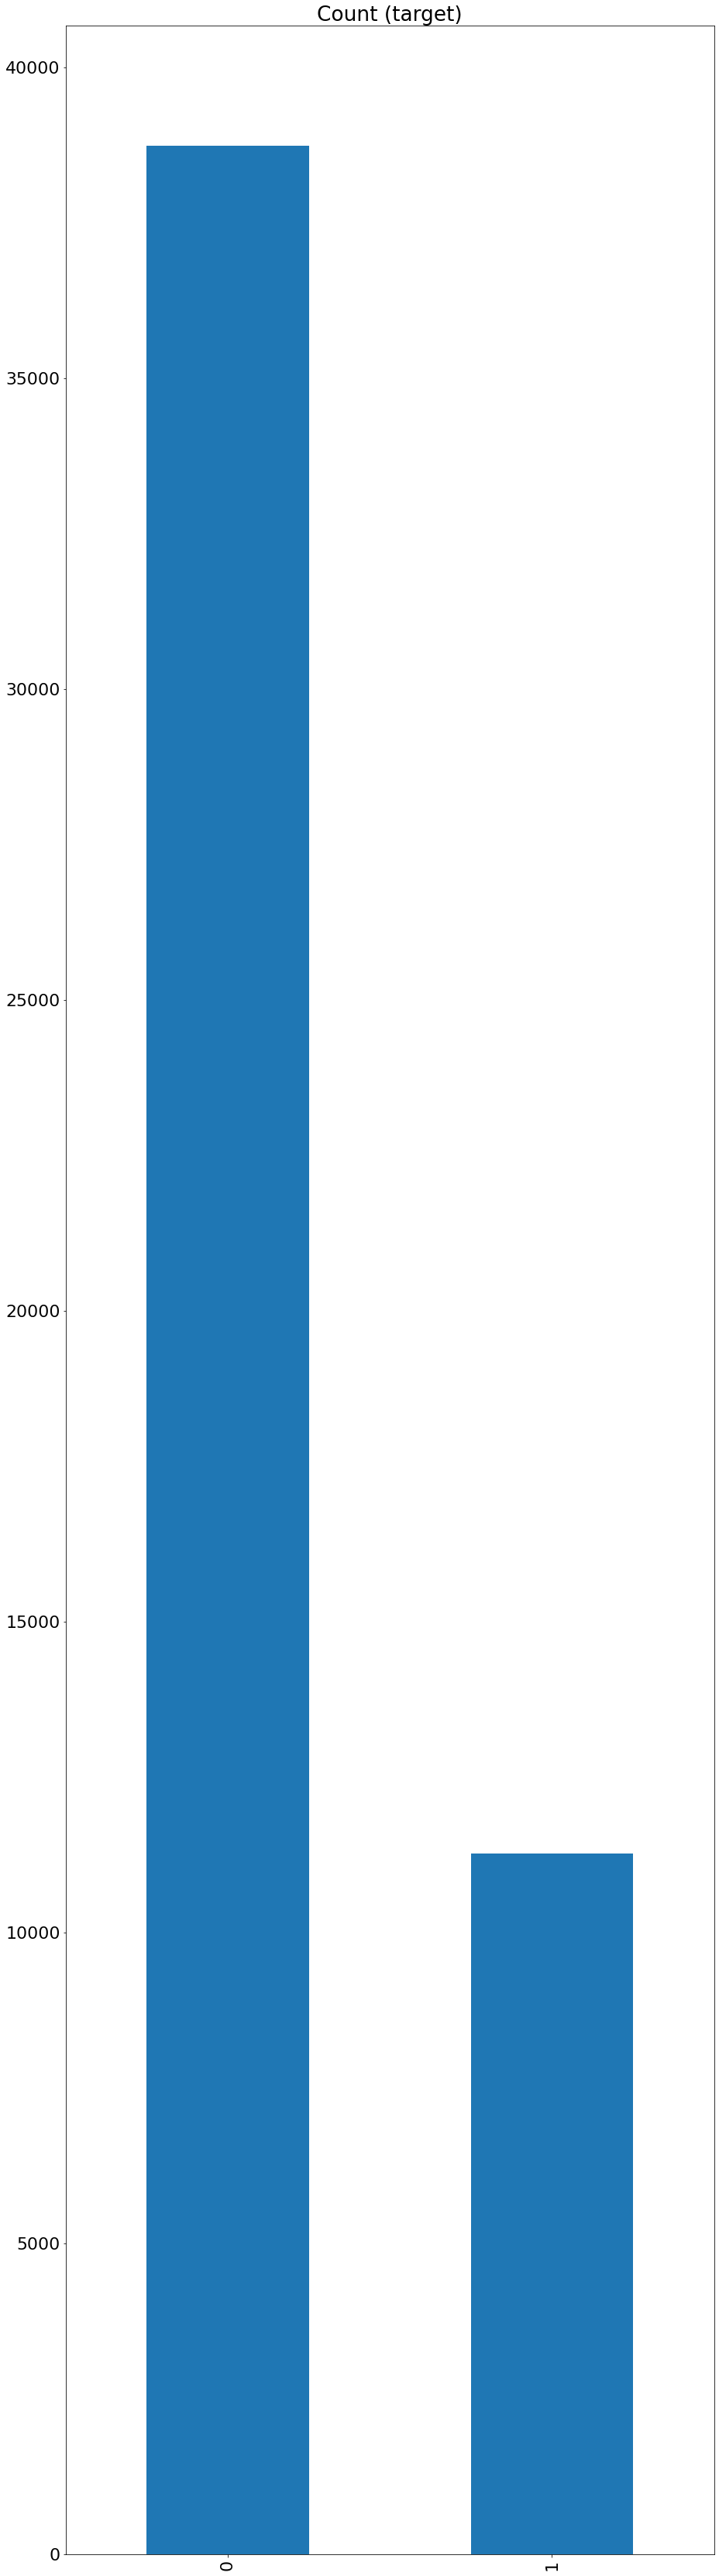

In [167]:
target_count = X_train.target.value_counts()
print('Class 0:', target_count[0])
print('Class 1:', target_count[1])
print('Proportion:', round(target_count[0] / target_count[1], 2), ': 1')

target_count.plot(kind='bar', title='Count (target)');

As we can see, the dataset is imbalanced.

## Unique values
How many unique values are there for each value in the data?

In [168]:
X_train.nunique(axis=0)

target       2
f0         505
f1          49
f2         413
f3         421
f4          16
f5         143
f6          62
f7          41
f8          15
f9           2
f10        278
f11        478
f12       1206
f13        486
f14         10
f15         41
f16        476
f17         16
f18         14
f19        495
f20         10
f21         16
f22        372
f23         30
f24        100
dtype: int64

In [169]:
X_train.f20.describe()

count    31245.000000
mean         4.428837
std          2.884968
min          0.000000
25%          1.000000
50%          5.000000
75%          7.000000
max          9.000000
Name: f20, dtype: float64

## Null values
We want to see how many null variables there are in each column. First, a sum of all null values in each column is displayed, then they are plotted for each column.

In [170]:
X_train.isnull().sum()

target        0
f0         4878
f1            0
f2         1184
f3          323
f4         3379
f5        23870
f6         3352
f7          483
f8         1460
f9          503
f10       21415
f11         106
f12        1513
f13         503
f14       20063
f15         943
f16         980
f17        1370
f18        1251
f19        4879
f20       18755
f21        3584
f22         254
f23       24840
f24         602
dtype: int64

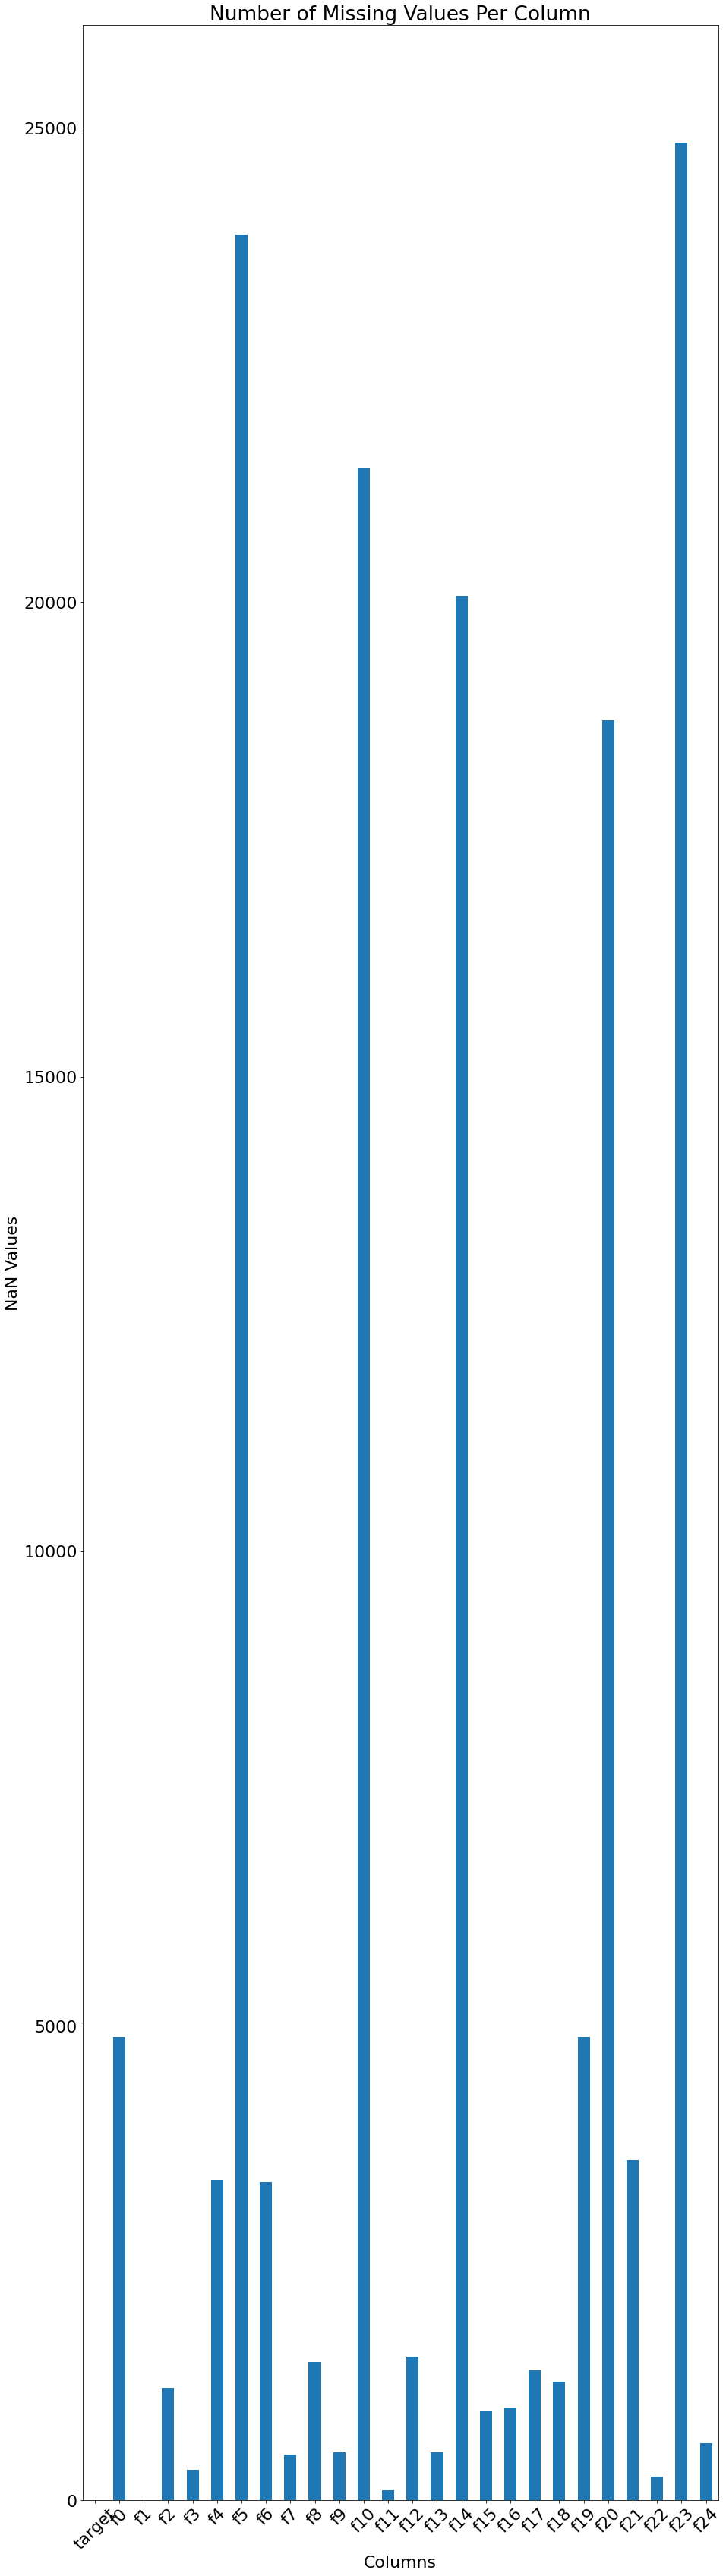

In [171]:
# plot missing data:
X_train.isnull().sum().plot(kind='bar')
# Add a title and show the plot.
plt.title('Number of Missing Values Per Column')
# Create tick mark labels on the Y axis and rotate them.
plt.xticks(rotation = 45)
# Create X axis label.
plt.xlabel("Columns")
# Create Y axis label.
plt.ylabel("NaN Values");

## Statistical analysis

In [172]:
X_train.describe()

,target,f0,f1,f2,f3,f5,f6,f7,f9,f10,...,f13,f14,f15,f16,f18,f19,f20,f22,f23,f24
count,50000.000000,45122.000000,50000.00000,48816.000000,49677.000000,26130.000000,46648.000000,49517.000000,49497.000000,28585.000000,...,49497.000000,29937.000000,49057.000000,49020.000000,48749.000000,45121.000000,31245.000000,49746.000000,25160.000000,49398.000000
mean,0.225320,1017.678647,23.49612,5.018887,16.998782,7.628550,40.050999,14.000848,0.222862,5.463607,...,2.379215,4.508668,18.686630,21.683570,7.305524,1015.285913,4.428837,12.191203,52.013712,68.806470
std,0.417797,7.130390,14.01738,0.007177,6.520973,3.776794,13.655620,8.936280,0.416171,4.251483,...,8.795403,2.717503,8.842879,6.970918,3.546719,7.057875,2.884968,6.414481,8.323467,19.024988
min,0.000000,982.000000,0.00000,4.998000,-6.200000,0.000000,7.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,-5.100000,0.000000,978.200000,0.000000,-8.500000,37.000000,1.000000
25%,0.000000,1013.000000,11.00000,5.014000,12.300000,4.900000,31.000000,7.000000,0.000000,2.600000,...,0.000000,2.000000,13.000000,16.600000,5.000000,1010.500000,1.000000,7.600000,45.000000,57.000000
50%,0.000000,1017.600000,23.00000,5.019100,16.700000,8.500000,39.000000,13.000000,0.000000,4.800000,...,0.000000,5.000000,19.000000,21.100000,7.000000,1015.300000,5.000000,12.000000,52.000000,70.000000
75%,0.000000,1022.500000,35.00000,5.024100,21.600000,10.600000,48.000000,19.000000,0.000000,7.400000,...,0.800000,7.000000,24.000000,26.500000,10.000000,1020.100000,7.000000,16.900000,59.000000,83.000000
max,1.000000,1040.900000,48.00000,5.045800,39.100000,14.300000,130.000000,87.000000,1.000000,145.000000,...,371.000000,9.000000,87.000000,46.100000,13.000000,1038.500000,9.000000,33.900000,66.000000,100.000000


Some noteable things to observe:
- f2 has a very low standard deviation, which means its values are almost the same for every sample. We can either drop this as a feature, or take the logarithm? This feature has missing values, making it easy to impute them.
- f6 has a high standard deviation
- many features has 0 as the minimum value - could be a placeholder for a missing value or human error?
- Several of the features have negative minimum values - is this an error? We will look at those features soon by plotting histograms of all values in e.g. f11 and f3
- Some features are actually integers

## Visualize the data

In [173]:
colors = {0.0:'orange', 1.0:'green'}

### Plot of f11

<AxesSubplot:ylabel='Frequency'>

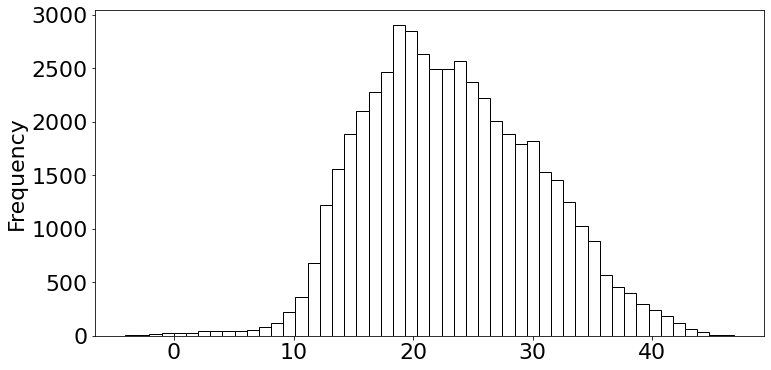

In [174]:
X_train['f11'].plot(kind='hist', bins=50, figsize=(12,6), facecolor='white',edgecolor='black')

In [175]:
below_0_f11 = X_train['f11'].apply(lambda x: x < 0).sum()
below_0_f11

47

In [176]:
X_train['f15'].apply(lambda x: x == 0).sum()

404

In [177]:
# Amount of samples below zero
below_0_f11/(50000-X_train['f11'].isnull().sum())

0.0009419970337114683

### Plot of f3

<AxesSubplot:ylabel='Frequency'>

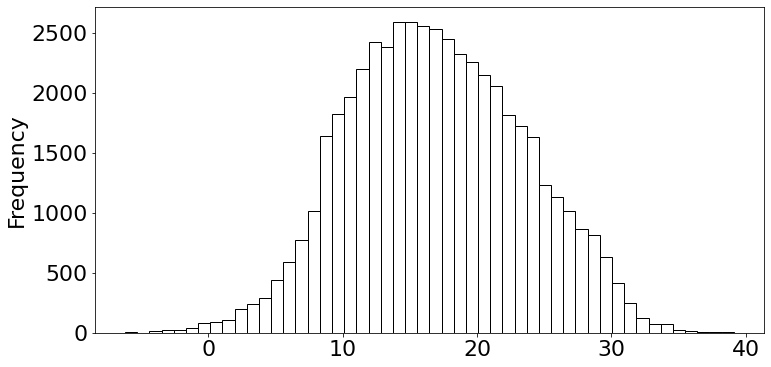

In [178]:
X_train['f3'].plot(kind='hist', bins=50, figsize=(12,6), facecolor='white',edgecolor='black')

In [179]:
below_0_f3 = X_train['f3'].apply(lambda x: x < 0).sum()
below_0_f3

167

In [180]:
# Amount of samples below zero
below_0_f3/(50000-X_train['f3'].isnull().sum())

0.0033617166898162127

### Plot the mean

Let's plot the mean of each feature:

<AxesSubplot:>

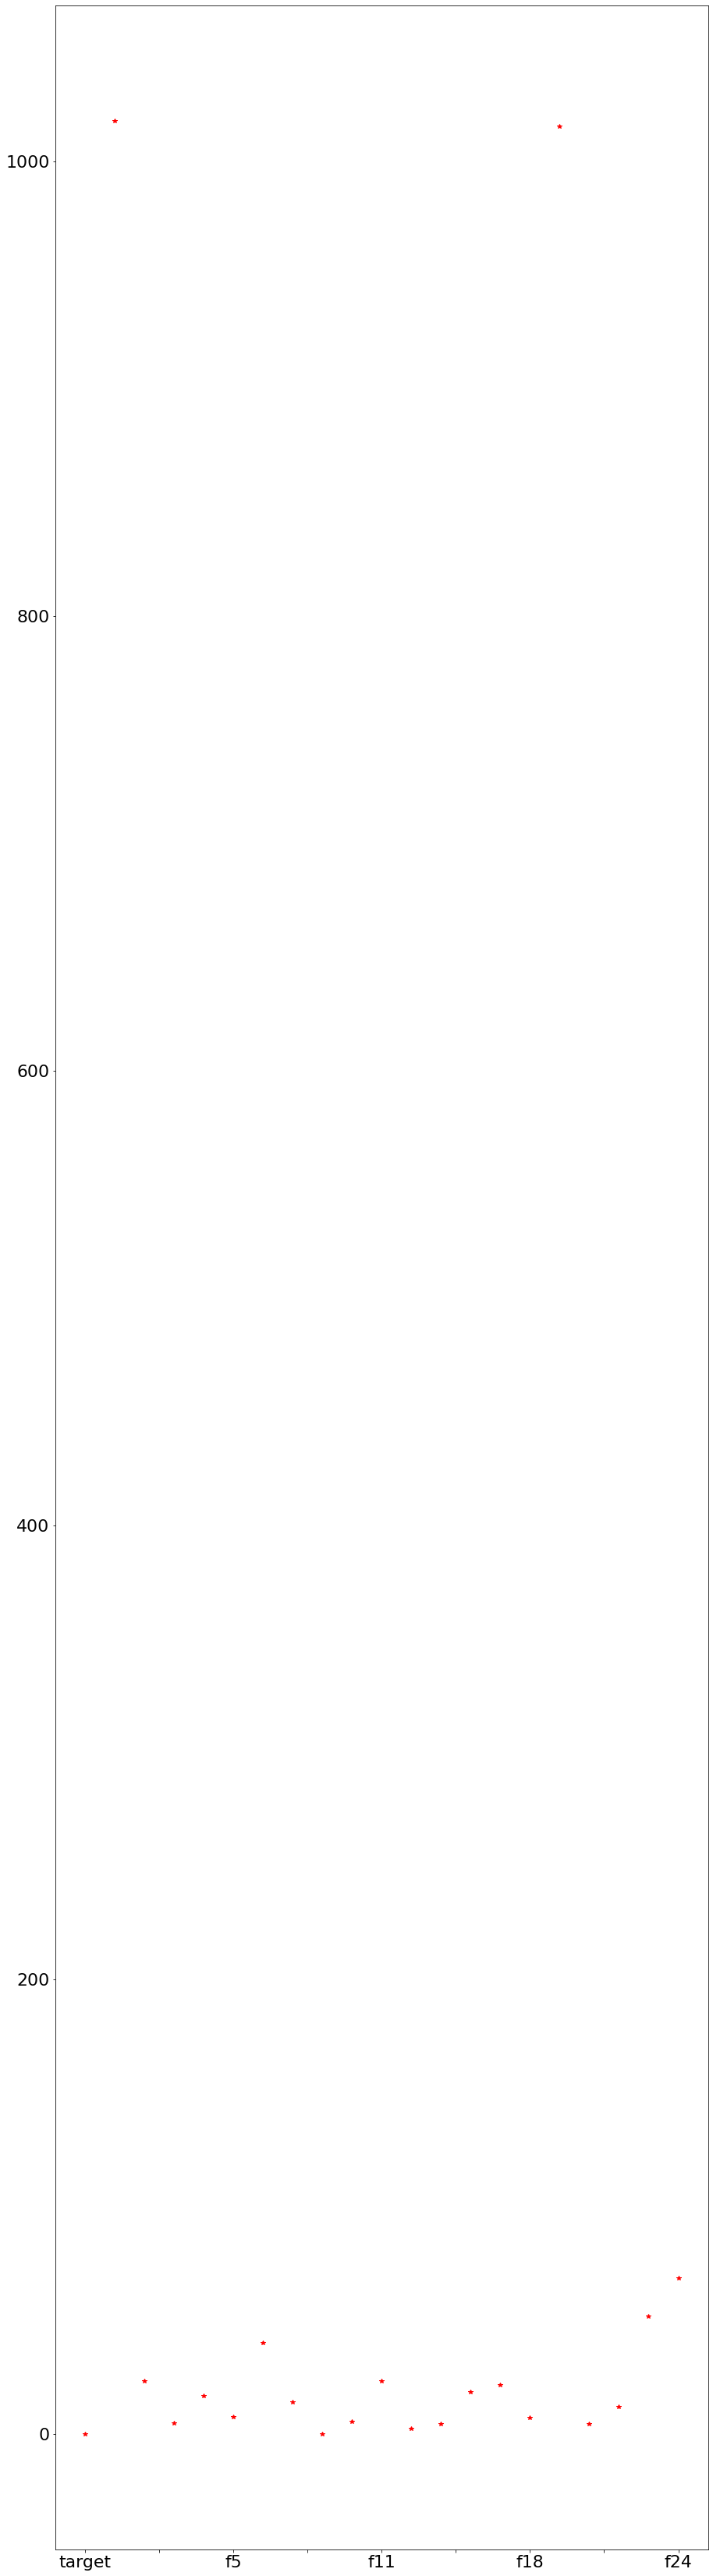

In [181]:
X_train.mean().plot(style='*', color='red')

Most of them are in the same range, except for f0 and f19. Let's remove them to better look at the others.

<AxesSubplot:>

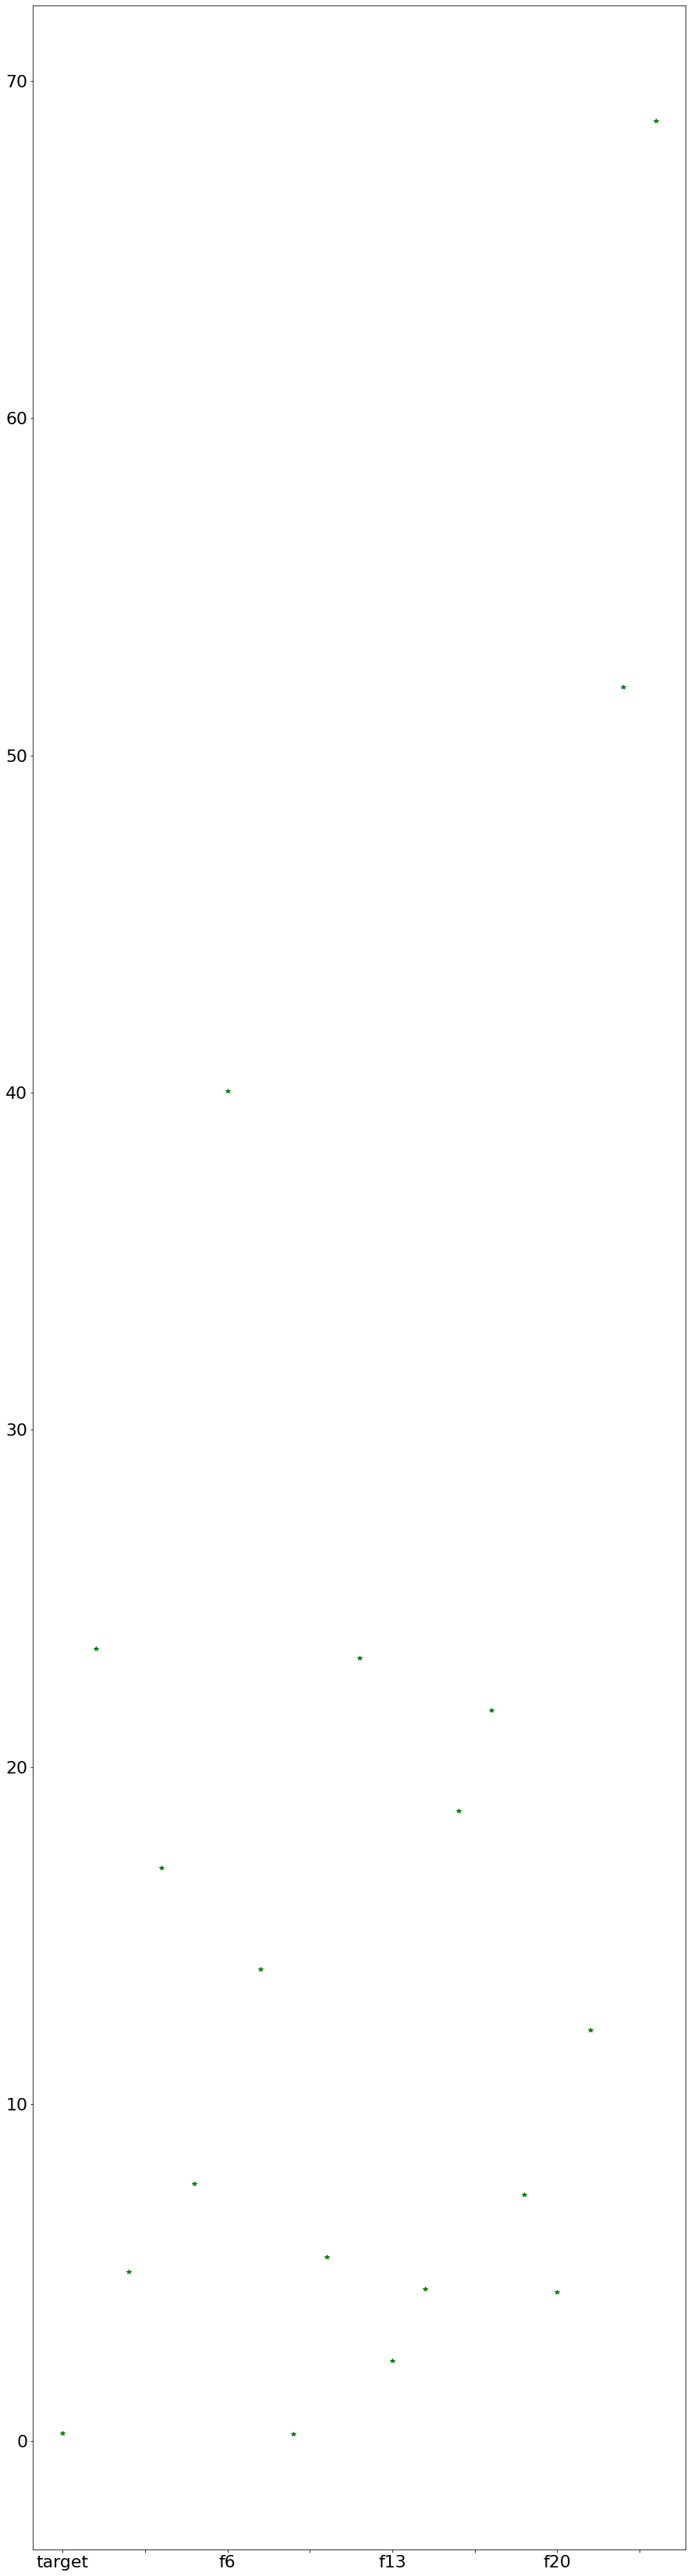

In [182]:
X_train.drop(['f0', 'f19'], axis=1).mean().plot(style='*', color='green')

### Correlations between variables

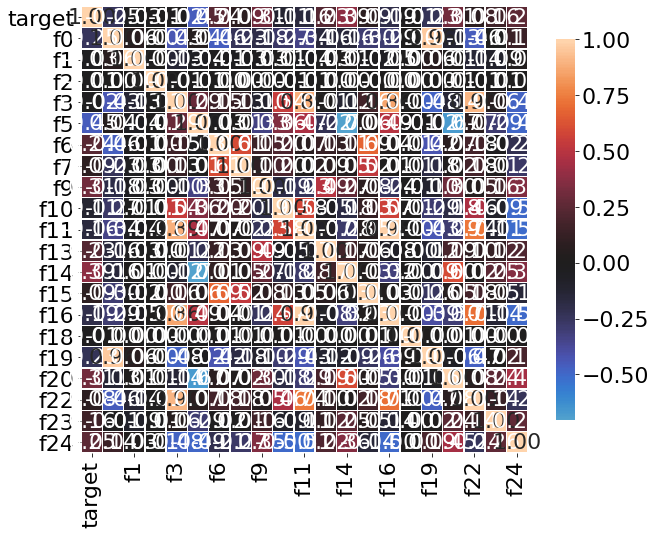

In [183]:
correlations = X_train.corr()

fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(correlations, vmax=1.0, center=0, fmt='.2f',
        square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .70})
plt.show();

This table has some interesting information. Many of the features are correlated, as presented in this list:

- **f0** - **f19**
- **f3** - f11, f16, **f22**
- f5 - f14, f20
- f6 - f7, f15
- f7 - f15
- f9 - f13
- **f11** - **f16**, f22, f24
- f14 - f20
- f16 - f22

The bold features are either highly positively or highly negativley correlated. The features f0 and f19, f3 and f22, and f11 and f16 are have correlation of 0.9 or above. This implies that the features are redundant of each other, and might cause overfitting.

Lets create scatterplots of all the features, and highlight the ones with the highest correlations: 

### Scatterplots of features

In [185]:
#sns_plot = sns.pairplot(X_train, hue='target')
#sns_plot.savefig('pairplot.png')
#sns_plot

### Scatterplots of highly correlated features

<AxesSubplot:xlabel='f0', ylabel='f19'>

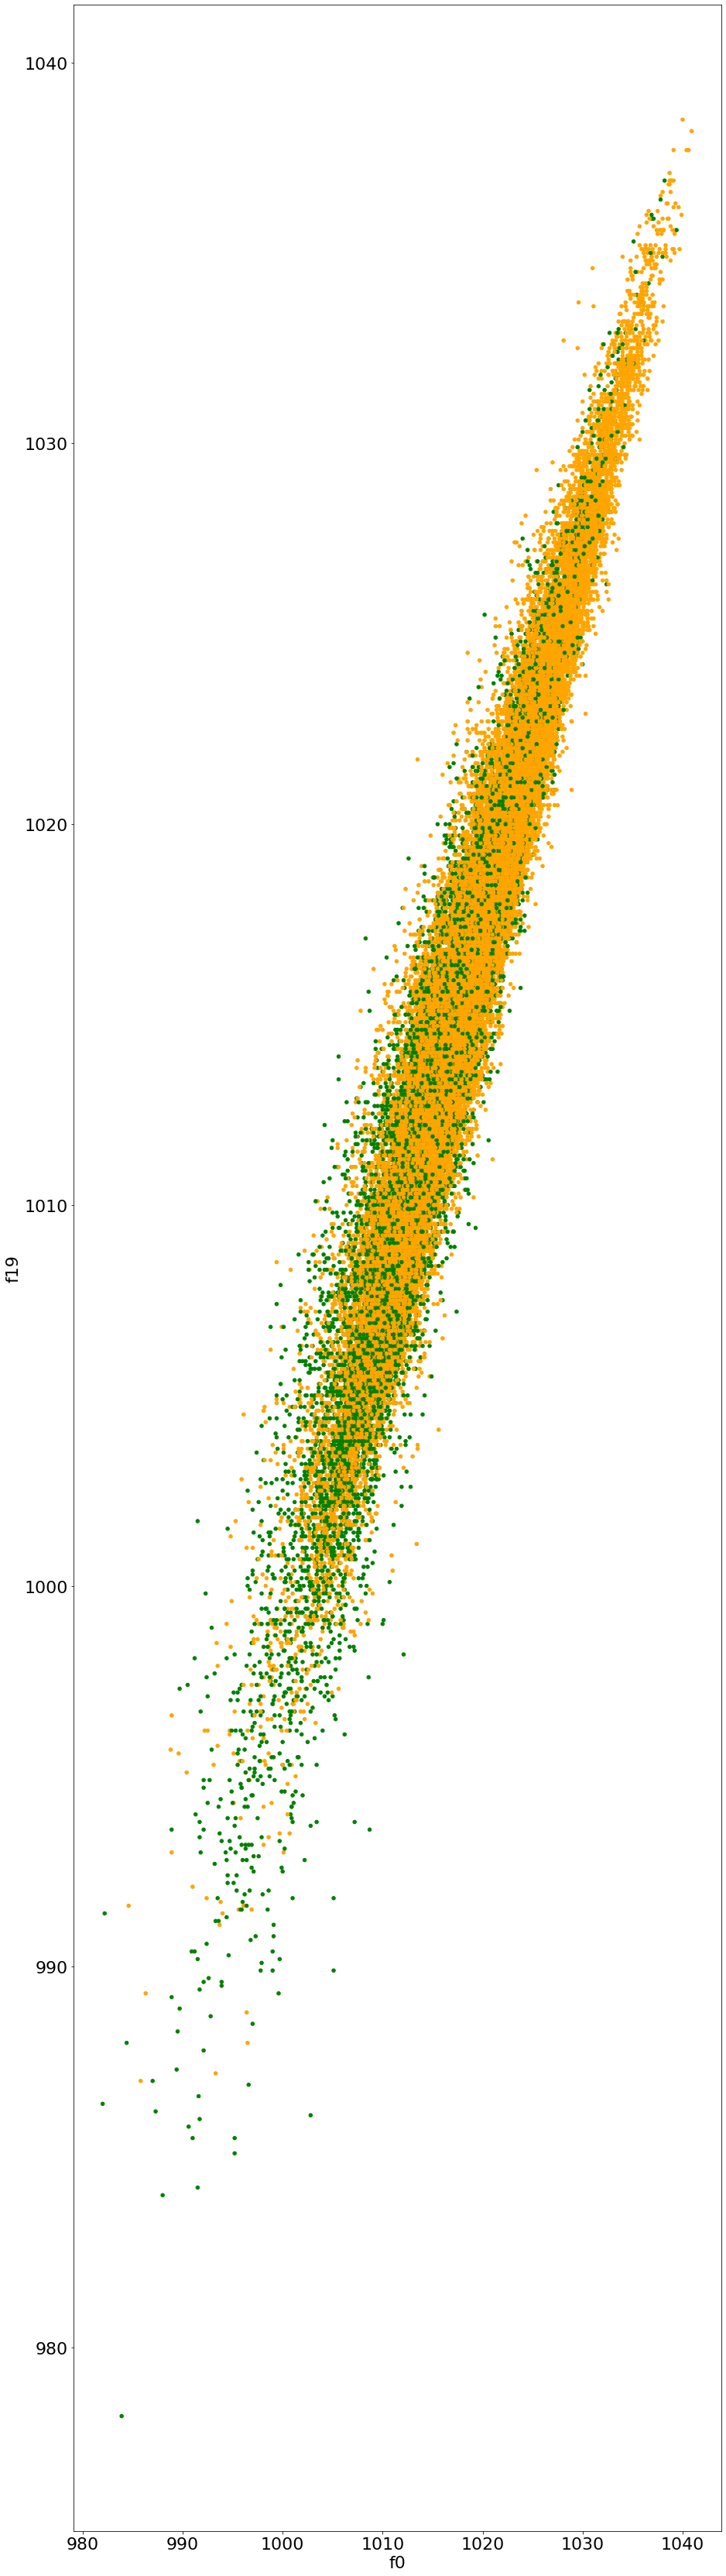

In [186]:
X_train.plot(kind='scatter', x='f0', y='f19', color=X_train['target'].apply(lambda x: colors[x]))

<AxesSubplot:xlabel='f3', ylabel='f22'>

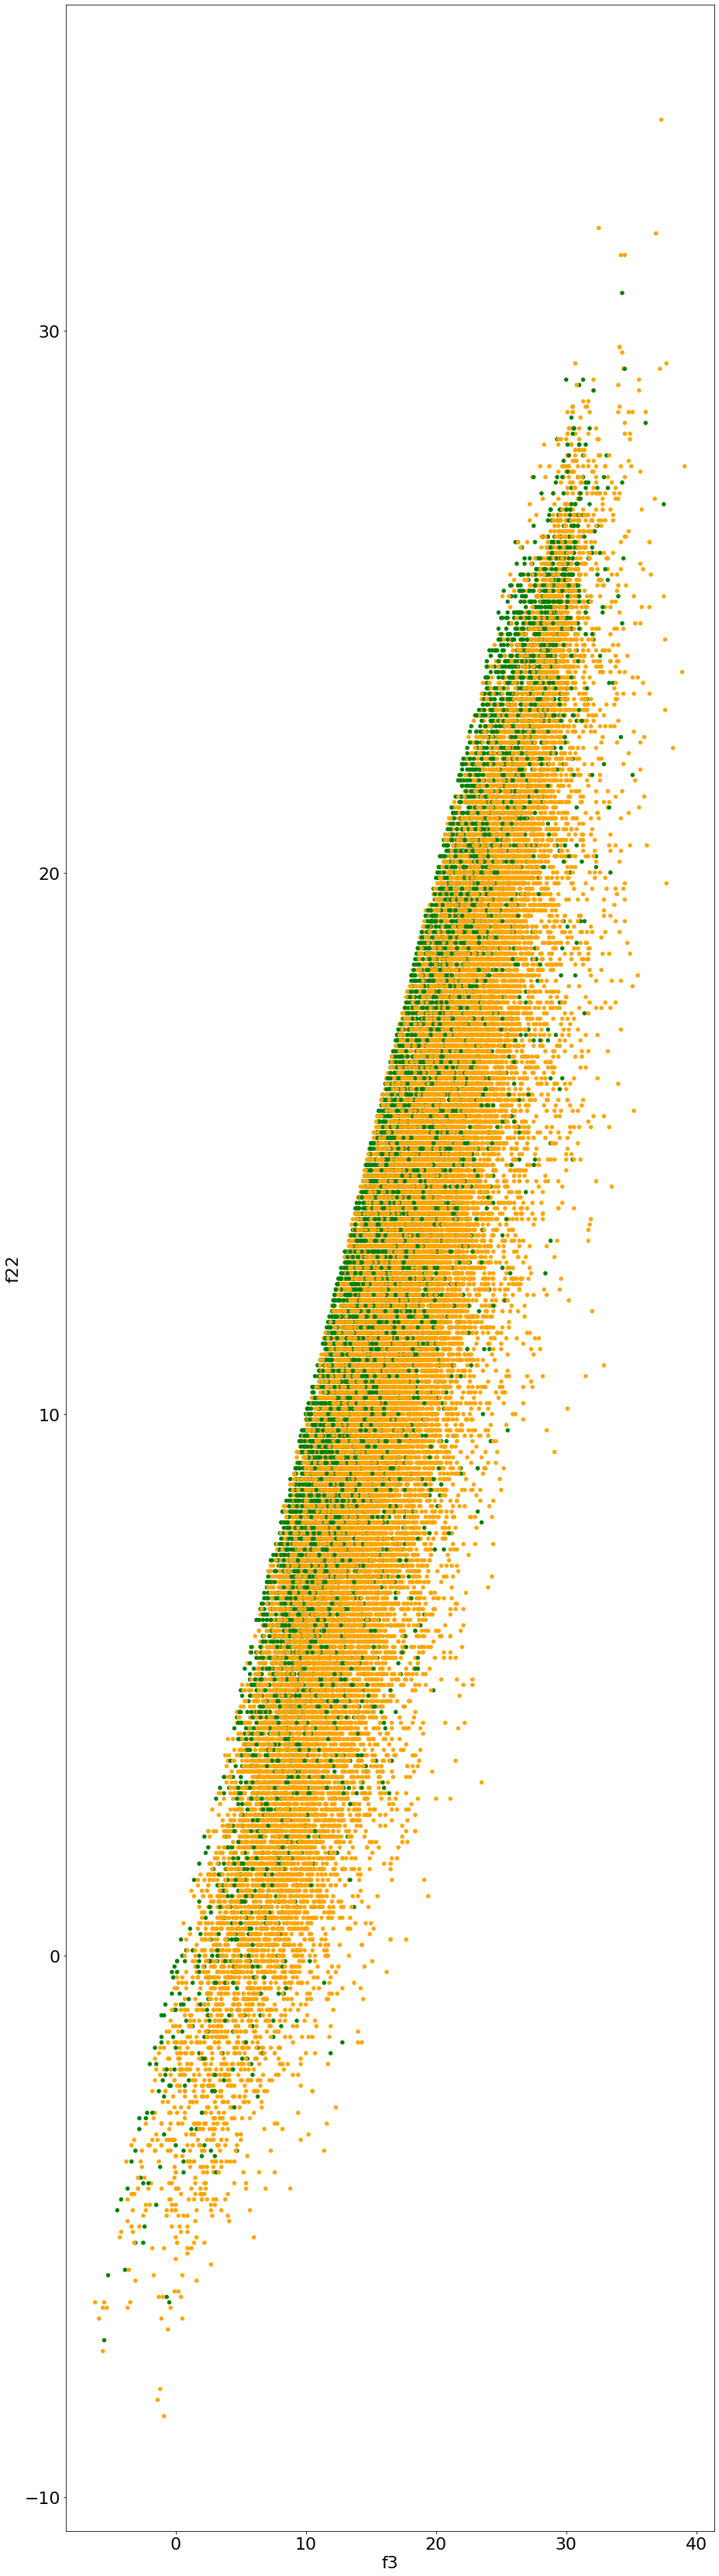

In [187]:
X_train.plot(kind='scatter', x='f3', y='f22', color=X_train['target'].apply(lambda x: colors[x]))

<AxesSubplot:xlabel='f11', ylabel='f16'>

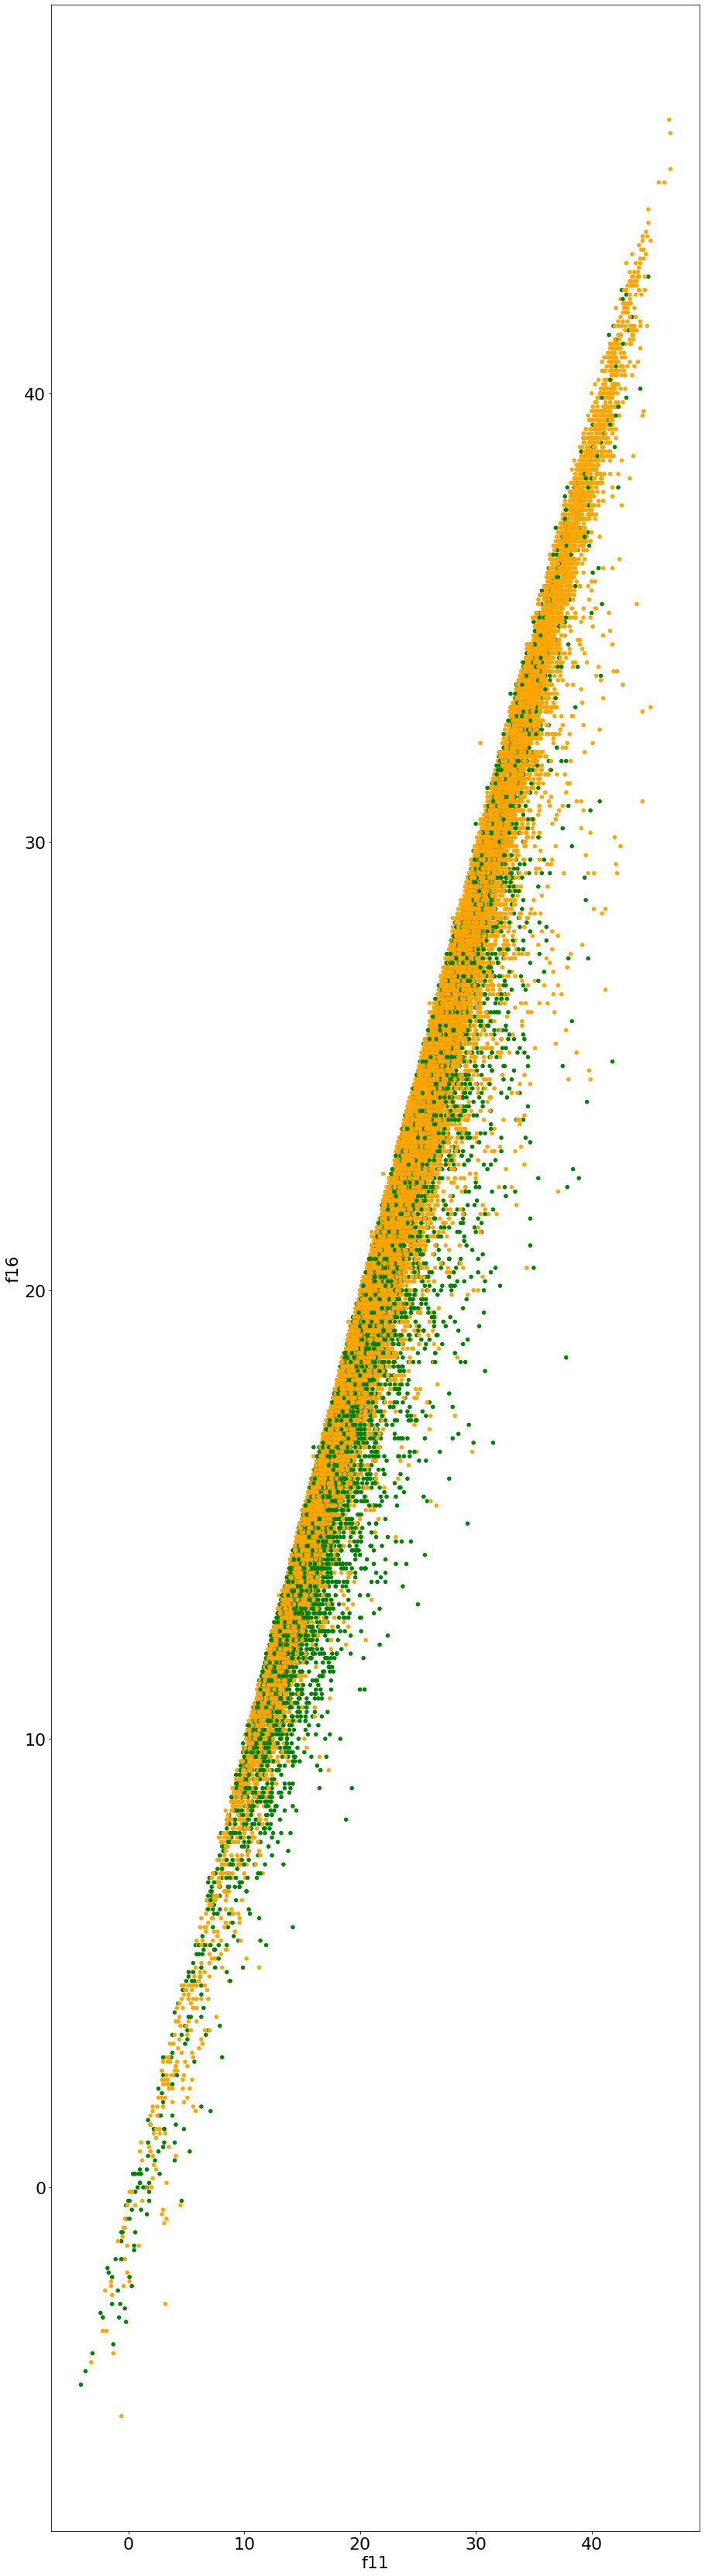

In [188]:
X_train.plot(kind='scatter', x='f11', y='f16', color=X_train['target'].apply(lambda x: colors[x]))

For decision tree methods and boosting methods like XGBoost, however, multicollinearity between features does not affect the result considerably because when the tree decides on where to split, it will choose only one of the perfectly correlated features. So we are good for now...

### Box plots
Let's find those outliers.

<AxesSubplot:>

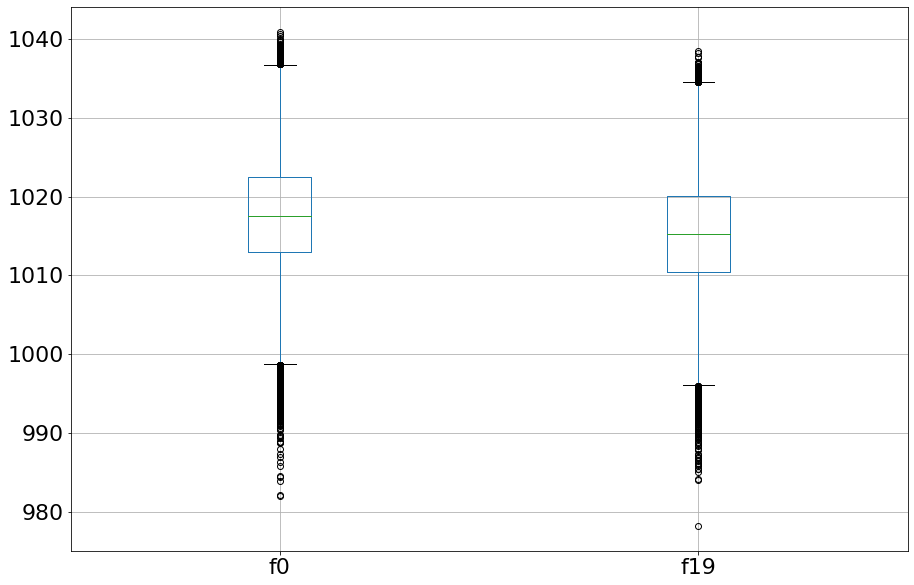

In [189]:
X_train.boxplot(['f0', 'f19'], figsize=(15,10))

<AxesSubplot:>

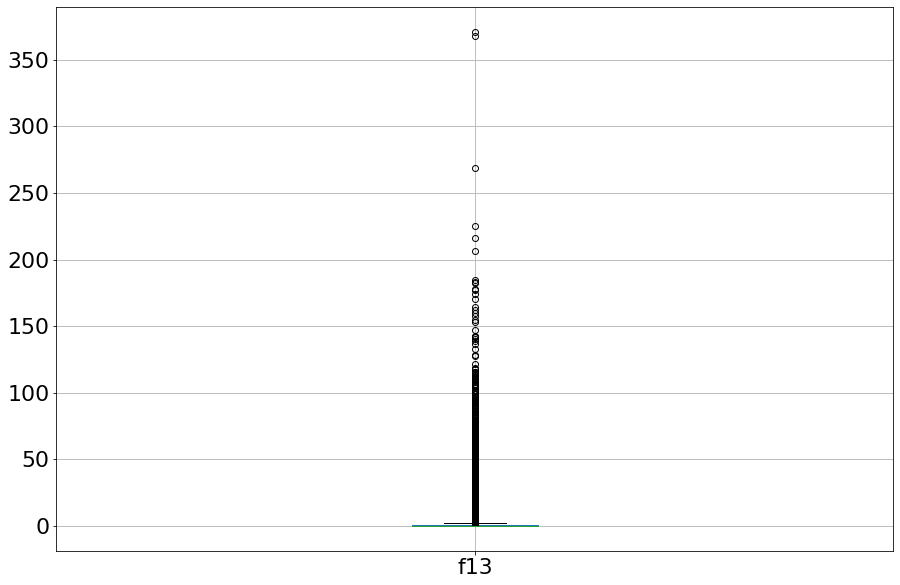

In [190]:
X_train.boxplot('f13', figsize=(15,10))

<AxesSubplot:>

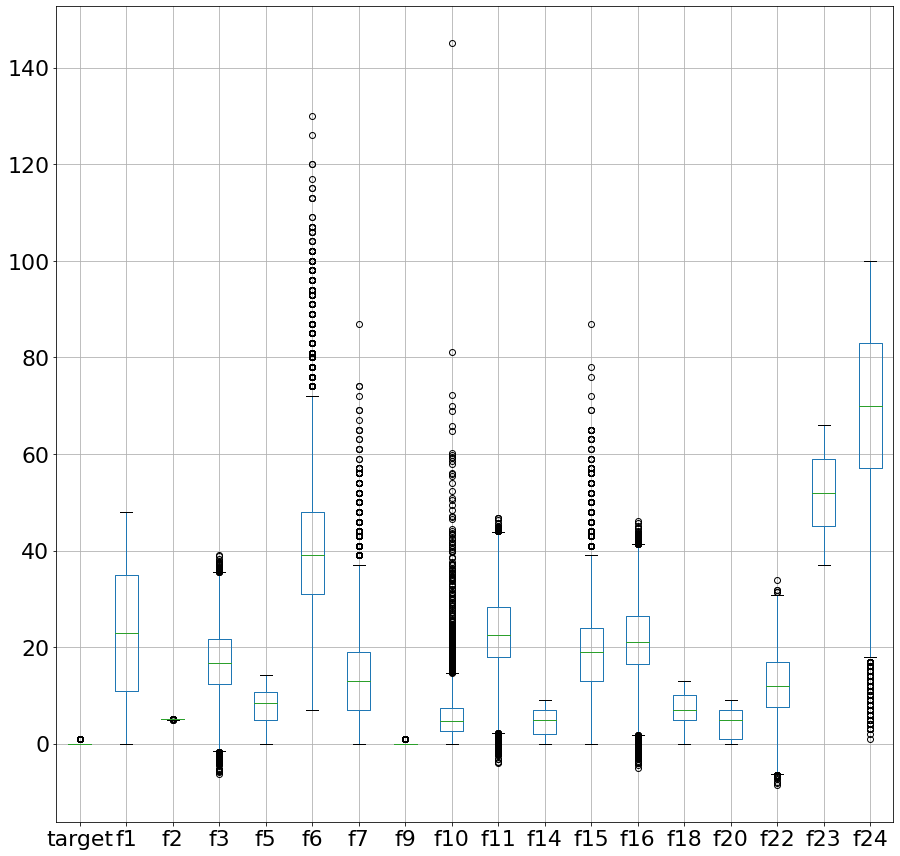

In [191]:
X_train.boxplot([x for x in X_train.drop(['f0', 'f19', 'f4', 'f8', 'f12', 'f17', 'f21', 'f13'], axis=1).columns], figsize=(15,15))

There are some outliers we can clearly see in this data.

## Find duplicates

Are there any exact duplicates of samples in the data? If there are, this might hurt the model's ability to generalize as it will "learn more" from the duplicated data.

In [192]:
X_train.duplicated().apply(lambda x: x is True).sum()

0

No duplicates. Great!

# Preprocessing the data

## Remove outliers

In [193]:
def find_skew(x):
    tmp=x.dropna()
    skew_value=skew(tmp)
    return 'sample lengh: %s   and skew: %s'%(len(tmp),skew_value)

Lets find the skew value for the features with obvious putliers, and try to lower it.

In [194]:
def print_skews():
    exclude = cat_cols + [hex_col]
    for col in X_train.drop(exclude, axis=1).columns:
        print(col, ': ', find_skew(X_train[col]))
        
print_skews()

target :  sample lengh: 50000   and skew: 1.314909887767842
f0 :  sample lengh: 45122   and skew: -0.08942690721996308
f1 :  sample lengh: 50000   and skew: 0.041465316694681204
f2 :  sample lengh: 48816   and skew: -0.14545019903223808
f3 :  sample lengh: 49677   and skew: 0.0775877961513525
f5 :  sample lengh: 26130   and skew: -0.5021855879232536
f6 :  sample lengh: 46648   and skew: 0.8630224707440753
f7 :  sample lengh: 49517   and skew: 0.7790643885914641
f9 :  sample lengh: 49497   and skew: 1.3318613270813682
f10 :  sample lengh: 28585   and skew: 4.512699109189178
f11 :  sample lengh: 49894   and skew: 0.21785047803962587
f13 :  sample lengh: 49497   and skew: 11.05542172973073
f14 :  sample lengh: 29937   and skew: -0.2295300544803834
f15 :  sample lengh: 49057   and skew: 0.6330558503818273
f16 :  sample lengh: 49020   and skew: 0.23634685216381526
f18 :  sample lengh: 48749   and skew: -0.2849660835833031
f19 :  sample lengh: 45121   and skew: -0.04659824449732003
f20 :  sa

We know f9 is a binary value, so it is expected to be a little "askew". Let's try to improve the skew value of f10 and f13 without losing too many samples

In [195]:
X_train.head()

,target,f0,f1,f2,f3,f4,f5,f6,f7,f8,...,f15,f16,f17,f18,f19,f20,f21,f22,f23,f24
0,0,1013.1,0,5.0190,26.1,bbd,11.1,33.0,11.0,m,...,19.0,27.8,bbd,6.0,1008.9,1.0,nd,17.4,61.0,63.0
1,0,1010.2,1,5.0142,10.4,n,NaN,46.0,17.0,k,...,22.0,12.7,n,12.0,1012.4,5.0,nx,6.8,55.0,80.0
2,0,1014.4,2,5.0280,12.3,xnx,NaN,31.0,13.0,c,...,9.0,13.0,nnd,7.0,1016.1,NaN,nx,10.1,61.0,70.0
3,0,1019.2,3,5.0335,23.0,nx,11.6,41.0,9.0,i,...,17.0,32.3,nx,10.0,1016.6,1.0,dnd,14.4,NaN,40.0
4,0,1027.6,4,5.0129,7.3,d,7.3,28.0,15.0,h,...,13.0,13.7,dnd,7.0,1024.4,7.0,dbd,6.8,47.0,92.0


In [196]:
X_train_outliers = X_train[train.f10<62]
find_skew(X_train_outliers['f10'])

'sample lengh: 28578   and skew: 2.890565628955878'

In [197]:
X_train_outliers = X_train[train.f13<200]
find_skew(X_train_outliers.f13)

'sample lengh: 49491   and skew: 8.181385154078031'

In [198]:
X_train = X_train_outliers
print_skews()

target :  sample lengh: 49491   and skew: 1.3363062095621212
f0 :  sample lengh: 44701   and skew: -0.09124577396554001
f1 :  sample lengh: 49491   and skew: 0.04138856417128502
f2 :  sample lengh: 48317   and skew: -0.14486430367399583
f3 :  sample lengh: 49249   and skew: 0.07828570723437252
f5 :  sample lengh: 25978   and skew: -0.5053998664983167
f6 :  sample lengh: 46207   and skew: 0.8621140077344968
f7 :  sample lengh: 49100   and skew: 0.7794673962476725
f9 :  sample lengh: 49491   and skew: 1.3325150446780893
f10 :  sample lengh: 28495   and skew: 4.517119917036553
f11 :  sample lengh: 49392   and skew: 0.22368351745782433
f13 :  sample lengh: 49491   and skew: 8.181385154078031
f14 :  sample lengh: 29776   and skew: -0.22753433266819353
f15 :  sample lengh: 48581   and skew: 0.6340531265608168
f16 :  sample lengh: 48545   and skew: 0.2409706922324196
f18 :  sample lengh: 48254   and skew: -0.284266362029079
f19 :  sample lengh: 44687   and skew: -0.04884789720627165
f20 :  sa

## Encode features

We need to One Hot Encode the categorical data, and also convert the hex values to decimal numbers

In [199]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49491 entries, 0 to 49999
Data columns (total 26 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   target  49491 non-null  int64  
 1   f0      44701 non-null  float64
 2   f1      49491 non-null  int64  
 3   f2      48317 non-null  float64
 4   f3      49249 non-null  float64
 5   f4      46180 non-null  object 
 6   f5      25978 non-null  float64
 7   f6      46207 non-null  float64
 8   f7      49100 non-null  float64
 9   f8      48050 non-null  object 
 10  f9      49491 non-null  float64
 11  f10     28495 non-null  float64
 12  f11     49392 non-null  float64
 13  f12     47989 non-null  object 
 14  f13     49491 non-null  float64
 15  f14     29776 non-null  float64
 16  f15     48581 non-null  float64
 17  f16     48545 non-null  float64
 18  f17     48160 non-null  object 
 19  f18     48254 non-null  float64
 20  f19     44687 non-null  float64
 21  f20     31096 non-null  float64
 22

In [200]:
X_train_encoded = X_train
X_train_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49491 entries, 0 to 49999
Data columns (total 26 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   target  49491 non-null  int64  
 1   f0      44701 non-null  float64
 2   f1      49491 non-null  int64  
 3   f2      48317 non-null  float64
 4   f3      49249 non-null  float64
 5   f4      46180 non-null  object 
 6   f5      25978 non-null  float64
 7   f6      46207 non-null  float64
 8   f7      49100 non-null  float64
 9   f8      48050 non-null  object 
 10  f9      49491 non-null  float64
 11  f10     28495 non-null  float64
 12  f11     49392 non-null  float64
 13  f12     47989 non-null  object 
 14  f13     49491 non-null  float64
 15  f14     29776 non-null  float64
 16  f15     48581 non-null  float64
 17  f16     48545 non-null  float64
 18  f17     48160 non-null  object 
 19  f18     48254 non-null  float64
 20  f19     44687 non-null  float64
 21  f20     31096 non-null  float64
 22

In [201]:
for i in cat_cols:
    X_train_encoded = pd.concat([X_train_encoded, pd.get_dummies(X_train[i], prefix=i)],axis=1)
    X_train_encoded.drop([i],axis=1, inplace=True)

In [202]:
X_train_encoded.head()

,target,f0,f1,f2,f3,f5,f6,f7,f9,f10,...,f21_dbd,f21_dnd,f21_n,f21_nd,f21_nnd,f21_nnx,f21_nx,f21_x,f21_xbx,f21_xnx
0,0,1013.1,0,5.0190,26.1,11.1,33.0,11.0,0.0,3.6,...,0,0,0,1,0,0,0,0,0,0
1,0,1010.2,1,5.0142,10.4,NaN,46.0,17.0,0.0,0.8,...,0,0,0,0,0,0,1,0,0,0
2,0,1014.4,2,5.0280,12.3,NaN,31.0,13.0,1.0,NaN,...,0,0,0,0,0,0,1,0,0,0
3,0,1019.2,3,5.0335,23.0,11.6,41.0,9.0,0.0,8.0,...,0,1,0,0,0,0,0,0,0,0
4,0,1027.6,4,5.0129,7.3,7.3,28.0,15.0,1.0,0.2,...,1,0,0,0,0,0,0,0,0,0


In [203]:
X_test_encoded = X_test
X_test_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 25 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f0      45095 non-null  float64
 1   f1      50000 non-null  int64  
 2   f2      48828 non-null  float64
 3   f3      49677 non-null  float64
 4   f4      46797 non-null  object 
 5   f5      25972 non-null  float64
 6   f6      46814 non-null  float64
 7   f7      49534 non-null  float64
 8   f8      48473 non-null  object 
 9   f9      49517 non-null  float64
 10  f10     28499 non-null  float64
 11  f11     49881 non-null  float64
 12  f12     48543 non-null  object 
 13  f13     49517 non-null  float64
 14  f14     29943 non-null  float64
 15  f15     49108 non-null  float64
 16  f16     49062 non-null  float64
 17  f17     48728 non-null  object 
 18  f18     48720 non-null  float64
 19  f19     45116 non-null  float64
 20  f20     31030 non-null  float64
 21  f21     46481 non-null  object 
 22

In [204]:
for i in cat_cols:
    X_test_encoded = pd.concat([X_test_encoded, pd.get_dummies(X_test[i], prefix=i)],axis=1)
    X_test_encoded.drop(i,axis=1, inplace=True)

In [205]:
X_test_encoded.head()

,f0,f1,f2,f3,f5,f6,f7,f9,f10,f11,...,f21_dbd,f21_dnd,f21_n,f21_nd,f21_nnd,f21_nnx,f21_nx,f21_x,f21_xbx,f21_xnx
0,1024.4,15,5.0256,6.6,0.8,20.0,2.0,0.0,0.2,11.6,...,0,0,0,0,0,0,0,0,0,0
1,1029.0,3,5.0289,5.6,9.0,28.0,0.0,0.0,1.8,14.8,...,0,0,0,0,0,0,0,0,0,0
2,1016.7,10,5.0081,22.3,NaN,31.0,6.0,0.0,NaN,34.3,...,0,0,0,0,0,0,0,0,0,0
3,1009.3,33,5.0168,11.3,NaN,31.0,11.0,1.0,NaN,16.2,...,0,1,0,0,0,0,0,0,0,0
4,1027.1,37,5.0205,12.6,12.6,22.0,6.0,0.0,5.0,22.3,...,0,0,0,0,0,0,0,0,0,0


In [206]:
X_train_encoded['f12_dec'] = X_train[hex_col].dropna().astype(str).apply(lambda x: int(x, 16))
X_test_encoded['f12_dec'] = X_test[hex_col].dropna().astype(str).apply(lambda x: int(x, 16))

In [207]:
X_train_encoded.drop([hex_col],axis=1, inplace=True)
X_test_encoded.drop([hex_col],axis=1, inplace=True)

In [208]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49491 entries, 0 to 49999
Data columns (total 26 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   target  49491 non-null  int64  
 1   f0      44701 non-null  float64
 2   f1      49491 non-null  int64  
 3   f2      48317 non-null  float64
 4   f3      49249 non-null  float64
 5   f4      46180 non-null  object 
 6   f5      25978 non-null  float64
 7   f6      46207 non-null  float64
 8   f7      49100 non-null  float64
 9   f8      48050 non-null  object 
 10  f9      49491 non-null  float64
 11  f10     28495 non-null  float64
 12  f11     49392 non-null  float64
 13  f12     47989 non-null  object 
 14  f13     49491 non-null  float64
 15  f14     29776 non-null  float64
 16  f15     48581 non-null  float64
 17  f16     48545 non-null  float64
 18  f17     48160 non-null  object 
 19  f18     48254 non-null  float64
 20  f19     44687 non-null  float64
 21  f20     31096 non-null  float64
 22

In [209]:
X_train_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49491 entries, 0 to 49999
Data columns (total 85 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   target   49491 non-null  int64  
 1   f0       44701 non-null  float64
 2   f1       49491 non-null  int64  
 3   f2       48317 non-null  float64
 4   f3       49249 non-null  float64
 5   f5       25978 non-null  float64
 6   f6       46207 non-null  float64
 7   f7       49100 non-null  float64
 8   f9       49491 non-null  float64
 9   f10      28495 non-null  float64
 10  f11      49392 non-null  float64
 11  f13      49491 non-null  float64
 12  f14      29776 non-null  float64
 13  f15      48581 non-null  float64
 14  f16      48545 non-null  float64
 15  f18      48254 non-null  float64
 16  f19      44687 non-null  float64
 17  f20      31096 non-null  float64
 18  f22      49302 non-null  float64
 19  f23      24902 non-null  float64
 20  f24      48972 non-null  float64
 21  f4_b     494

### Removing null values

For ML methods that do not handle Null values, we need to iumpute the value of missing values in the data.

For the XGBoost algorithm, we do not need to remove the null variables as these will be handled as "missing". However, for other algorithms we might need to imputate them from other data points.

In [210]:
#for col in X_train.columns:
#    values = X_train[col]
#    if values.dtype in ['int', 'float']:
#        values_mean = values.mean()
#        values.fillna(values_mean, inplace=True)

#X_train.isnull().sum()

### Remove duplicate rows

We already established that there are no duplicates in the data, but if there were, we could drop them by running:

In [211]:
X_train_encoded = X_train_encoded.drop_duplicates()
X_train_encoded.shape

(49491, 85)

We did, however, have some redundant features. For the features with a , I will feature with the least samples

### f0 and f19

# Save the data to csv files

In [212]:
X_train_encoded.to_csv('data/prepared_train_data.csv')

In [213]:
X_test_encoded.to_csv('data/prepared_test_data.csv')

In [249]:
np.savetxt('data/target_train_data.csv', Y_train, fmt='%d')

# Create model and predict

In [214]:
X_train_encoded.head()

,target,f0,f1,f2,f3,f5,f6,f7,f9,f10,...,f21_dnd,f21_n,f21_nd,f21_nnd,f21_nnx,f21_nx,f21_x,f21_xbx,f21_xnx,f12_dec
0,0,1013.1,0,5.0190,26.1,11.1,33.0,11.0,0.0,3.6,...,0,0,1,0,0,0,0,0,0,5.107194e+10
1,0,1010.2,1,5.0142,10.4,NaN,46.0,17.0,0.0,0.8,...,0,0,0,0,0,1,0,0,0,1.575127e+10
2,0,1014.4,2,5.0280,12.3,NaN,31.0,13.0,1.0,NaN,...,0,0,0,0,0,1,0,0,0,3.867297e+10
3,0,1019.2,3,5.0335,23.0,11.6,41.0,9.0,0.0,8.0,...,1,0,0,0,0,0,0,0,0,5.913853e+10
4,0,1027.6,4,5.0129,7.3,7.3,28.0,15.0,1.0,0.2,...,0,0,0,0,0,0,0,0,0,6.458888e+10


## Resampling

In [215]:
# split data into train and test sets
seed = 7
test_size = 0.33
X_train_cleaned = X_train_encoded.drop('target', axis=1)
Y_train = X_train["target"].values
X_tr, X_te, y_tr, y_te = train_test_split(X_train_cleaned, Y_train, test_size=test_size, random_state=seed)

In [216]:
from collections import Counter
# count examples in each class
counter = Counter(y_tr)

# estimate scale_pos_weight value
estimate = counter[0] / counter[1]
print('Estimate: %.3f' % estimate)

Estimate: 3.506


# XGBoost

In [217]:
import xgboost as xgb
from sklearn import metrics
from sklearn.model_selection import GridSearchCV

def auc(m, train, test): 
    return (metrics.roc_auc_score(y_tr,m.predict_proba(train)[:,1]),
                            metrics.roc_auc_score(y_te,m.predict_proba(test)[:,1]))

In [244]:
# Parameter Tuning
model = xgb.XGBClassifier()
param_dist = {"max_depth": [10,30,50],
              "min_child_weight" : [1,3,6],
              "n_estimators": [200],
              "learning_rate": [0.05, 0.1,0.16],}
grid_search = GridSearchCV(model, param_grid=param_dist, cv = 3, 
                                   verbose=10, n_jobs=-1)
grid_search.fit(X_tr, y_tr)

grid_search.best_estimator_

Fitting 3 folds for each of 108 candidates, totalling 324 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   45.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  19 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  20 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  22 tasks      | elapsed:  1

KeyboardInterrupt: 

In [ ]:
"""
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=10,
              min_child_weight=6, missing=nan, monotone_constraints='()',
              n_estimators=200, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)
"""

In [245]:
# Parameter Tuning
model = xgb.XGBClassifier()
param_dist = {"max_depth": [5,10],
              "min_child_weight" : [6],
              "n_estimators": [500],
              "learning_rate": [0.05, 0.01, 0.001],
             "scale_pos_weight": [1, 3.56, 100, 1000]}
grid_search = GridSearchCV(model, param_grid=param_dist, cv = 3, 
                                   verbose=10, n_jobs=-1)
grid_search.fit(X_tr, y_tr)

grid_search.best_estimator_

Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   49.7s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  7.8min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  9.0min
[Parallel(n_jobs=-1)]: Done  65 out of  72 | elapsed: 11.7min remaining:  1.3min
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed: 12.4min finished


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=5,
              min_child_weight=6, missing=nan, monotone_constraints='()',
              n_estimators=500, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

### grid_search.best_params_

In [263]:
model = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=10,
              min_child_weight=6, monotone_constraints='()',
              n_estimators=200, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)
model.fit(X_tr, y_tr)

auc(model, X_tr, X_te)

(0.9785601575883235, 0.8812676234975926)

In [220]:
model.save_model('xgboost_model.json')

# Make predictions

In [221]:
pred1 = model.predict_proba(X_test_encoded)
pred1
id_pred1 = pd.DataFrame({'sample_id': test['id'].astype(int), 'prediction_in_probability': pred1[:,1]})
id_pred1.head(20)

,sample_id,prediction_in_probability
0,50000,0.062624
1,50001,0.019105
2,50002,0.031399
3,50003,0.931199
4,50004,0.006038
5,50005,0.285593
6,50006,0.019936
7,50007,0.350615
8,50008,0.019304
9,50009,0.628994


In [222]:
np.savetxt('predictions.txt', id_pred1, fmt=['%d', '%.6f'], delimiter=',')

In [223]:
# make predictions for test data
y_pred = model.predict(X_te)
predictions = [round(value) for value in y_pred]

# Analyze model

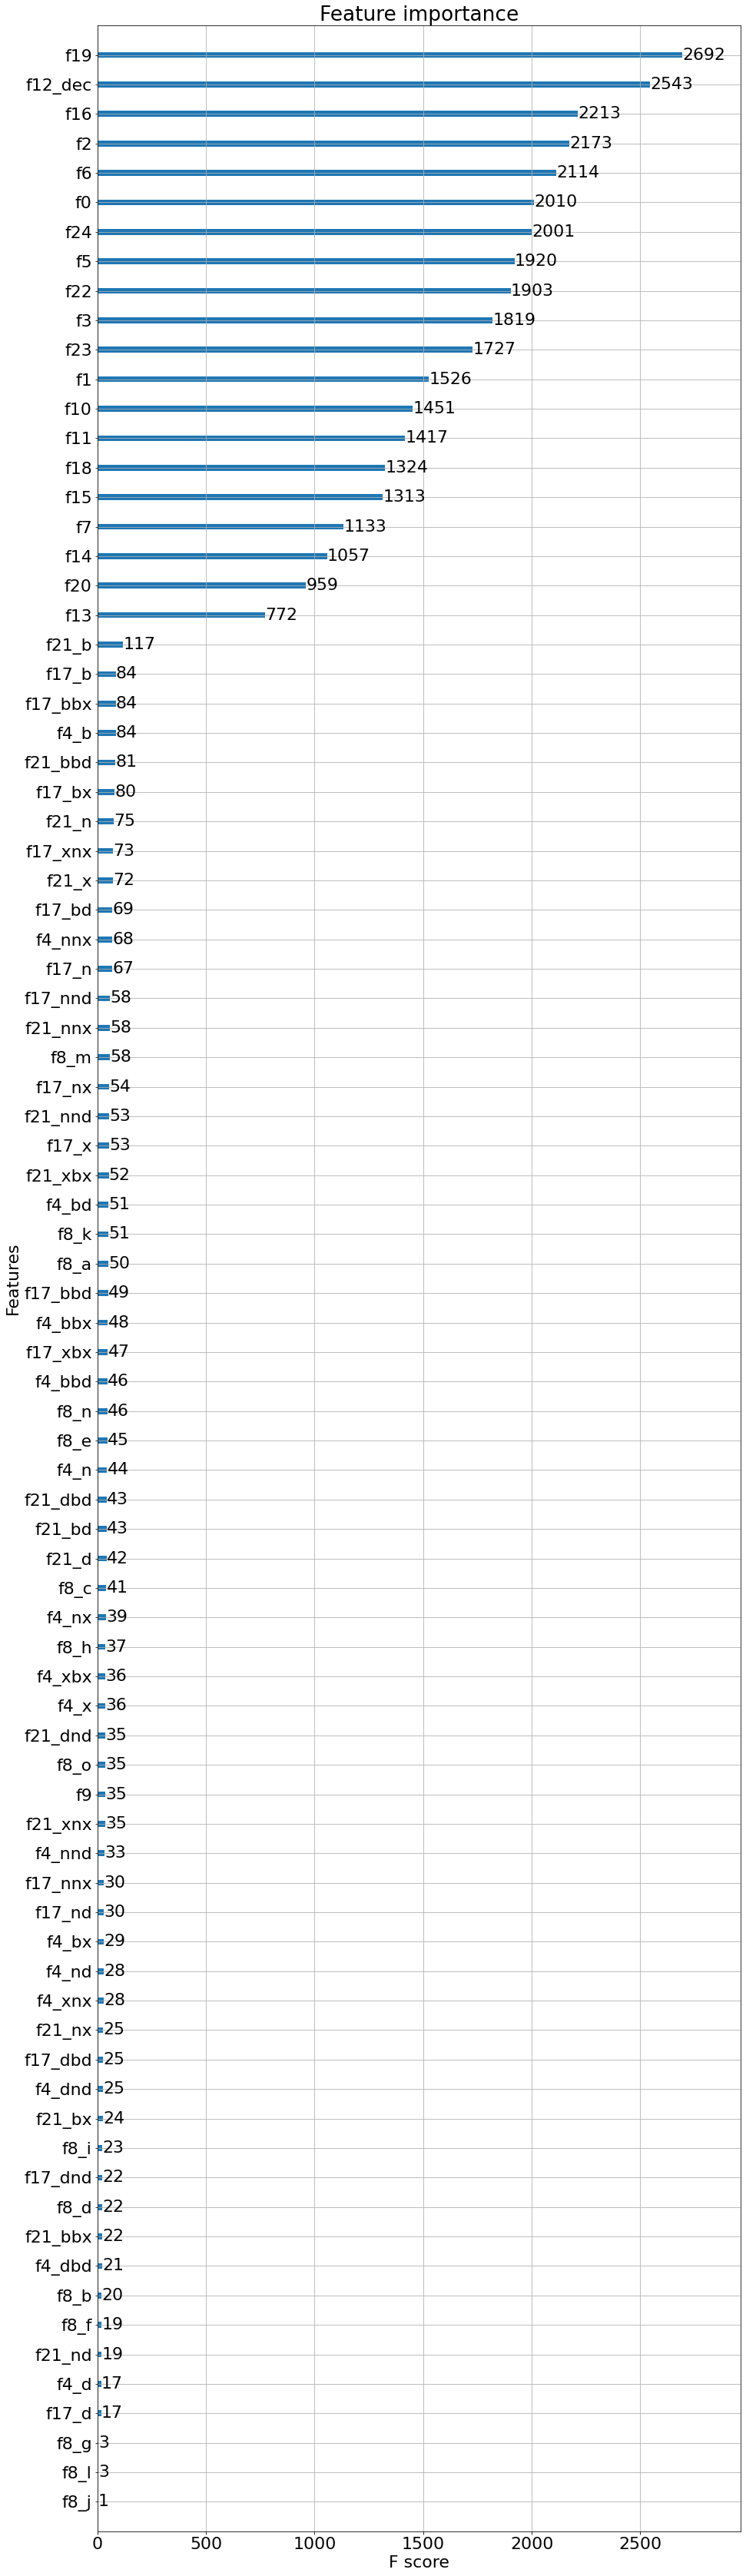

<Figure size 1080x4320 with 0 Axes>

In [224]:
%matplotlib inline
from matplotlib import pyplot
from matplotlib.pylab import rcParams
rcParams.update({'font.size': 22})
rcParams['figure.figsize'] = 15,60

xgb.plot_importance(model)
pyplot.show()
pyplot.savefig('feature_importance.png')

In [225]:
model.feature_importances_

array([0.00951972, 0.00904456, 0.00696579, 0.00979398, 0.02494323,
       0.01827711, 0.00772348, 0.00541282, 0.00818233, 0.00976122,
       0.10704759, 0.03785507, 0.00866735, 0.01387046, 0.007212  ,
       0.01751654, 0.0093795 , 0.01100541, 0.02732232, 0.01226407,
       0.01265153, 0.01110623, 0.01078455, 0.01216965, 0.00914302,
       0.00843247, 0.00771389, 0.00973394, 0.01043695, 0.01053624,
       0.00773799, 0.01090542, 0.00885777, 0.00867676, 0.00904406,
       0.00676267, 0.0082774 , 0.00847832, 0.00812315, 0.00683504,
       0.0095513 , 0.00717596, 0.00782547, 0.00621693, 0.00977404,
       0.00459612, 0.00757969, 0.02995613, 0.00799334, 0.00678095,
       0.00808629, 0.01147912, 0.00848665, 0.01249762, 0.01397063,
       0.01174746, 0.00807404, 0.01008798, 0.01070142, 0.00886603,
       0.00836805, 0.00831216, 0.01030438, 0.01204595, 0.01007113,
       0.00984384, 0.01182295, 0.00950778, 0.01481009, 0.00768557,
       0.01358539, 0.01365429, 0.00834281, 0.00990147, 0.00901

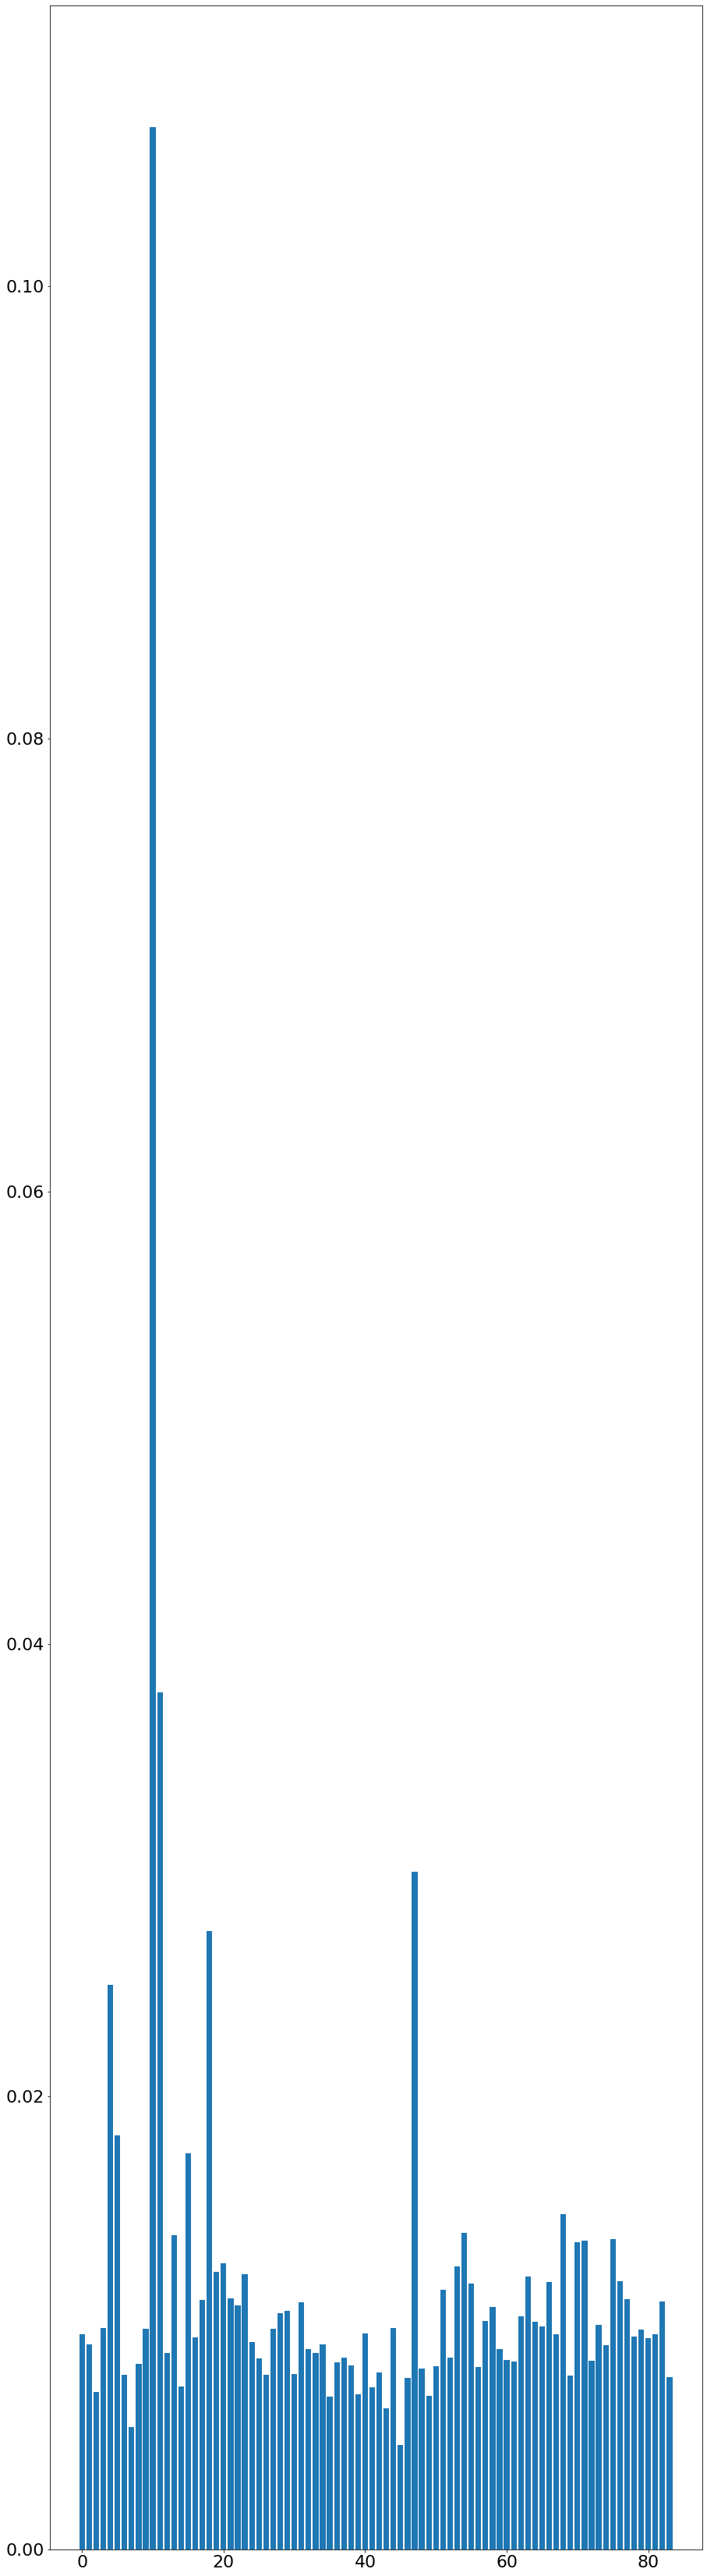

In [226]:
pyplot.bar(range(len(model.feature_importances_)), model.feature_importances_)
pyplot.show()

# Feature selection
From the bar chart, we see that most features are below 0.01 in feature importance. Let's select the features above this threshold.

In [258]:
dropping = [X_tr.columns[i] for i in range(len(X_tr.columns)) if model.feature_importances_[i] < 0.009]


In [229]:
dropping

['f2',
 'f7',
 'f9',
 'f10',
 'f15',
 'f18',
 'f4_d',
 'f4_dbd',
 'f4_nnd',
 'f4_nx',
 'f4_x',
 'f4_xnx',
 'f8_a',
 'f8_b',
 'f8_c',
 'f8_d',
 'f8_f',
 'f8_g',
 'f8_h',
 'f8_j',
 'f8_k',
 'f8_m',
 'f8_n',
 'f8_o',
 'f17_bbd',
 'f17_d',
 'f17_n',
 'f17_nd',
 'f17_nnd',
 'f21_bbx',
 'f21_d',
 'f12_dec']

In [259]:
selected_X_train = X_tr.drop(dropping, axis=1)
selected_X_test = X_te.drop(dropping, axis=1)

In [246]:
selected_X_train.to_csv("data/selected_train_data.csv")
selected_X_test.to_csv("data/selected_test_data.csv")

In [231]:
selection_model = xgb.XGBClassifier()
param_dist = {"max_depth": [10,30,50],
              "min_child_weight" : [1,3,6],
              "n_estimators": [200],
              "learning_rate": [0.05, 0.1,0.16],}
grid_search2 = GridSearchCV(selection_model, param_grid=param_dist, cv = 3, 
                                   verbose=10, n_jobs=-1)
grid_search2.fit(selected_X_train, y_tr)

grid_search2.best_estimator_

Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


KeyboardInterrupt: 

In [261]:
selection_model = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=10,
              min_child_weight=6, monotone_constraints='()',
              n_estimators=200, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

selection_model.fit(selected_X_train, y_tr)

auc(selection_model, selected_X_train, selected_X_test)

(0.9876401153835618, 0.8820262184833209)

In [233]:
selected_y_pred = selection_model.predict_proba(selected_X_test)
selected_y_pred

array([[0.9503035 , 0.04969649],
       [0.686244  , 0.313756  ],
       [0.09427595, 0.90572405],
       ...,
       [0.99699175, 0.00300827],
       [0.99885434, 0.00114566],
       [0.7920189 , 0.20798114]], dtype=float32)

# LigthGBM

In [235]:
import lightgbm as lgb
from sklearn import metrics

def auc2(m, train, test): 
    return (metrics.roc_auc_score(y_tr,m.predict(train)),
                            metrics.roc_auc_score(y_te,m.predict(test)))

In [ ]:
lg = lgb.LGBMClassifier(silent=False)
param_dist = {"max_depth": [25,50, 75],
              "learning_rate" : [0.01,0.05,0.1],
              "num_leaves": [300,900,1200],
              "n_estimators": [200]
             }
grid_search = GridSearchCV(lg, n_jobs=-1, param_grid=param_dist, cv = 3, scoring="roc_auc", verbose=5)
grid_search.fit(selected_X_train, y_tr)
grid_search.best_estimator_

In [ ]:
"""
LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.05, max_depth=50,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=200, n_jobs=-1, num_leaves=300, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=False,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)
"""

In [236]:
d_train = lgb.Dataset(selected_X_train, label=y_tr)
params = {"max_depth": 50, "learning_rate" : 0.05, "num_leaves": 300,  "n_estimators": 300}

# Without Categorical Features
model2 = lgb.train(params, d_train)
auc2(model2, selected_X_train, selected_X_test)

/home/anja/.local/lib/python3.8/site-packages/lightgbm/engine.py:151: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000865 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2264
[LightGBM] [Info] Number of data points in the train set: 33158, number of used features: 52
[LightGBM] [Info] Start training from score 0.221907


(0.9996593961958824, 0.875140598391603)

# CatBoost

In [ ]:
import catboost as cb

def auc3(m, train, test): 
    return (metrics.roc_auc_score(y_tr,m.predict_proba(train)[:,1]),
                            metrics.roc_auc_score(y_te,m.predict_proba(test)[:,1]))

params = {'depth': [4, 7, 10],
          'learning_rate' : [0.03, 0.1, 0.15],
         'l2_leaf_reg': [1,4,9],
         'iterations': [300]}
catboost = cb.CatBoostClassifier()
cb_model = GridSearchCV(catboost, params, scoring="roc_auc", cv = 3)
cb_model.fit(selected_X_train, y_tr)

In [ ]:
cb_model.best_params_

In [ ]:
clf = cb.CatBoostClassifier(eval_metric="AUC", depth=7, iterations= 300, l2_leaf_reg= 9, learning_rate= 0.1)
clf.fit(selected_X_train,y_tr)

In [ ]:
auc(clf, selected_X_train, X_te)